In [78]:
import sys
sys.path += ["../src"]
import utils
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
# import jl_nflows_geo_coordinates_2 as nfg
# from jl_nflows_geo_coordinates import load_nf as load_dict

from _51_abm_functions import cod_prov_abbrv_df

# Global Spatial Autocorrelation
from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
from spatial_autocorrelation import get_localMoransI, LISA_scatterplot
from sklearn.preprocessing import MinMaxScaler

"""
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
"""

'\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.neural_network import MLPClassifier\n\n\nfrom sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score\nfrom sklearn.metrics import roc_curve, roc_auc_score\nfrom sklearn.metrics import precision_recall_curve, average_precision_score\n'

In [79]:
# transform one-hot encoding to categories
def add_cat_features(df):
    df["energy_class"] = df[[u for u in df.columns if "_energy" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]
    df["COD_CAT"] = [u[8:] for u in df[[u for u in df.columns if "COD_CAT_" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    df["anno_costruzione"] = [u[17:] for u in df[[u for u in df.columns if "ANNO_COSTRUZIONE" in u]].stack().rename("col").reset_index().query("col == 1")["level_1"]]
    return df

## Loading data from Jacopo's synthetic data

In [80]:
# import dictionary with data {'hydro_risk', 'census', 'omi_og', 'cap'}
# takes ~25seconds
geo_dict = jl_vae.load_geo_data()

# check which provinces are done
glob(jl_vae.path_pop_synth + f"95sample/pop_samples/*")

['/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250806priceFE.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703LT.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703FI.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703CE.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703BT.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250806priceKR.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703SI.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250703CO.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples/synthetic_pop_full_250811priceMC.csv',
 '/data/housing/data/intermediate/jl_pop_synth/95sample/pop_samples

In [81]:
import pickle

prov = "AN"

with open(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle', 'rb') as f:
    all_baselines = pickle.load(f)

In [82]:
all_baselines.keys()

dict_keys(['df_real', 'df_real95', 'df_nfvae', 'df_nfvae95', 'df_ablation', 'df_ablation95', 'df_ipf', 'df_ipf95', 'df_copula_nf', 'df_copula_nf95', 'df_copula_ablation', 'df_copula_ablation95'])

In [83]:
all_baselines['df_real']

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,y,x,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,...,COD_CAT_A_04_05,floor_0.0,floor_1.0,floor_2.0,floor_3.0,floor_Missing,floor_plus_4,log_price,flag_air_conditioning_Missing,flag_multi_floor_Missing
0,1.0,0.0,0.0,0.0,43.615,13.528,4.605170,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.813030,1.0,1.0
1,0.0,0.0,0.0,0.0,43.437,13.609,4.304065,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.082143,1.0,1.0
2,0.0,0.0,0.0,0.0,43.439,13.610,5.293305,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.512925,1.0,1.0
3,1.0,0.0,0.0,0.0,43.658,13.149,4.634729,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.813030,1.0,1.0
4,0.0,0.0,0.0,0.0,43.615,13.519,4.532599,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.608236,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,1.0,0.0,0.0,0.0,43.530,13.441,4.770685,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.982929,1.0,1.0
4248,1.0,0.0,0.0,0.0,43.532,13.401,5.068904,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.100712,1.0,1.0
4249,1.0,0.0,0.0,0.0,43.534,13.399,5.010635,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.427743,1.0,1.0
4250,0.0,0.0,0.0,0.0,43.530,13.441,4.955827,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.407565,0.0,1.0


In [84]:
all_baselines['df_real95']

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,y,x,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,...,COD_CAT_A_04_05,floor_0.0,floor_1.0,floor_2.0,floor_3.0,floor_Missing,floor_plus_4,log_price,flag_air_conditioning_Missing,flag_multi_floor_Missing
277,1.0,1.0,0.0,0.0,43.726,13.163,5.220356,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.206073,1.0,1.0
1644,0.0,0.0,0.0,0.0,43.606,13.500,4.736198,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.472103,1.0,1.0
4001,0.0,0.0,0.0,0.0,43.606,13.495,4.406719,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.082143,0.0,1.0
265,1.0,1.0,0.0,0.0,43.626,13.296,5.247024,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.695247,1.0,1.0
1756,0.0,1.0,0.0,0.0,43.619,13.528,4.624973,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.849398,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,0.0,0.0,0.0,0.0,43.608,13.505,4.077537,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.645425,1.0,1.0
1419,1.0,0.0,0.0,0.0,43.438,13.642,4.510860,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.086726,1.0,1.0
9,1.0,0.0,0.0,0.0,43.524,13.394,4.406719,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.736069,1.0,1.0
2335,0.0,1.0,0.0,0.0,43.738,13.189,3.713572,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.798104,1.0,1.0


In [85]:
baseline_path = "/data/housing/data/intermediate/jl_pop_synth/pop_samples/baselines"
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]

df_real = all_baselines['df_real'] 
df_real95 = all_baselines['df_real95']
df_excluded = df_real[~df_real.index.isin(df_real95.index)]

# nf + VAE
df_nfvae = all_baselines['df_nfvae'] 
df_nfvae95 = all_baselines['df_nfvae95'] 
# ablation (only VAE)
df_vae = all_baselines['df_ablation']
df_vae95 = all_baselines['df_ablation95']
# ipf
df_ipf = all_baselines['df_ipf'] 
df_ipf95 = all_baselines['df_ipf95'] 
# copula + nf (95%)
df_copulanf = all_baselines['df_copula_nf']
df_copulanf95 = all_baselines['df_copula_nf95']
# copula (95%)
df_copula = all_baselines['df_copula_ablation']
df_copula95 = all_baselines['df_copula_ablation95']


## fixing data types in syn pop data and get dataframes with the same columns

In [86]:
def ConvertBool2number(df):
    bool_cols = df.select_dtypes(include=bool).columns
    df[bool_cols] = df[bool_cols].astype(float)
    df = df.reset_index(drop=True)
    return df


In [87]:
df_real = ConvertBool2number(df_real)
df_real95 = ConvertBool2number(df_real95)
df_excluded = ConvertBool2number(df_excluded)

# nf + VAE
df_nfvae = ConvertBool2number(df_nfvae)
df_nfvae95 = ConvertBool2number(df_nfvae95)
# ablation (only VAE)
df_vae = ConvertBool2number(df_vae)
df_vae95 = ConvertBool2number(df_vae95)
# ipf
df_ipf = ConvertBool2number(df_ipf)
df_ipf95 = ConvertBool2number(df_ipf95)
# copula + nf
df_copulanf = ConvertBool2number(df_copulanf)
df_copulanf95 = ConvertBool2number(df_copulanf95)
# copula
df_copula = ConvertBool2number(df_copula)
df_copula95 = ConvertBool2number(df_copula95)


Putting all the data in the same space and rescale columns between 0 and 1

In [88]:
df_real95['descr'] = 0 #'real95'
df_excluded['descr'] = 1 #'real_excluded'
# nf + VAE
df_nfvae['descr'] = 2 #'nfvae'
df_nfvae95['descr'] = 3 #'nfvae95'
# ablation (only VAE)
df_vae['descr'] = 4 #'vae'
df_vae95['descr'] = 5 #'vae95'
# ipf
df_ipf['descr'] = 6 #'ipf'
df_ipf95['descr'] = 7 #'ipf95'
# copula + nf
df_copulanf['descr'] = 8 #'copulanf'
df_copulanf95['descr'] = 9 #'copulanf95'
# copula
df_copula['descr'] = 10 #'copula'
df_copula95['descr'] = 11 #'copula95'

df = pd.concat([df_real95,df_excluded,
                df_nfvae,df_nfvae95,
                df_vae,df_vae95,
                df_ipf,df_ipf95,
                df_copulanf,df_copulanf95,
                df_copula,df_copula95])

df = (df-df.min())/(df.max()-df.min())
df

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,y,x,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,...,floor_0.0,floor_1.0,floor_2.0,floor_3.0,floor_Missing,floor_plus_4,log_price,flag_air_conditioning_Missing,flag_multi_floor_Missing,descr
0,1.0,1.0,0.0,0.0,0.951374,0.420027,0.590914,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.563594,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.696006,0.815078,0.476087,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.410254,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.696006,0.809216,0.397944,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.328785,0.0,1.0,0.0
3,1.0,1.0,0.0,0.0,0.738567,0.575937,0.597239,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.456873,1.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.723670,0.847901,0.449707,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.489078,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,0.0,0.0,0.0,0.0,0.864123,0.357897,0.533947,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.426593,1.0,1.0,1.0
4035,1.0,0.0,0.0,0.0,0.604499,0.847901,0.582124,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.742339,1.0,1.0,1.0
4036,0.0,1.0,0.0,0.0,0.642804,0.693163,0.493826,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.415145,1.0,1.0,1.0
4037,1.0,0.0,0.0,0.0,0.521504,0.427060,0.461569,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.412425,1.0,1.0,1.0


In [89]:
# separate dafaframe again
name_keys = ['real95','real_excluded',
             'nfvae','nfvae95',
             'vae','vae95',
             'ipf','ipf95',
             'copulanf','copulanf95',
             'copula','copula95']

unique_descr = df.descr.unique()
data = dict()
for i in range(len(name_keys)):
    a = df.loc[df.descr == unique_descr[i],:].drop(columns='descr').reset_index(drop=True)
    data[name_keys[i]] = a

In [90]:
for i in data.keys():
    print(i,' num of rows =', len(data[i]),' num of columns=', len(data[i].columns) )


real95  num of rows = 4039  num of columns= 29
real_excluded  num of rows = 213  num of columns= 29
nfvae  num of rows = 4252  num of columns= 29
nfvae95  num of rows = 4039  num of columns= 29
vae  num of rows = 4252  num of columns= 29
vae95  num of rows = 4039  num of columns= 29
ipf  num of rows = 4252  num of columns= 29
ipf95  num of rows = 4039  num of columns= 29
copulanf  num of rows = 4252  num of columns= 29
copulanf95  num of rows = 4039  num of columns= 29
copula  num of rows = 4252  num of columns= 29
copula95  num of rows = 4039  num of columns= 29


## Distance function

In [91]:
from sklearn.metrics import pairwise_distances
import gower

def TableIMS(data, control_data,train_data='real95', test_data = 'real_excluded',metric='euclidean'):
    res = pd.DataFrame(columns=['frac_train','frac_test'])
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            train_dists = pairwise_distances(data[train_data].values, data[i].values, metric='euclidean') 
            test_dists = pairwise_distances(data[test_data].values, data[i].values, metric='euclidean') 
        elif(metric=='norm1'):
            train_dists = pairwise_distances(data[train_data].values, data[i].values, metric='minkowski', p=1)
            test_dists = pairwise_distances(data[test_data].values, data[i].values, metric='minkowski', p=1)
        elif(metric == 'gower'):
            train_dists = gower.gower_matrix(data[train_data], data[i])
            test_dists = gower.gower_matrix(data[test_data], data[i])
        
        # take the minimum distances
        min_dists_train = train_dists.min(axis=1)
        min_dists_test = test_dists.min(axis=1)

        res.loc[i,:] = [np.sum(min_dists_train==0)/len(min_dists_train), np.sum(min_dists_test==0)/len(min_dists_test)]

    return res



## Identical Match Counts (IMS)
Here we check how many samples of the training set (real data used to train the generative algortithm) have been duplicated inside the synthetic data

In [92]:
control_data = ['nfvae','nfvae95', 'vae','vae95','ipf','ipf95', 'copulanf','copulanf95','copula','copula95']
res_IMS_eu = TableIMS(data, control_data)
res_IMS_norm1 = TableIMS(data, control_data,metric='norm1')
res_IMS_gower = TableIMS(data, control_data, metric='gower')
#res_IMS_norm1 = TableDistance(data=data,control_data=control_data,test_data = 'real95',metric='norm1')
#res_IMS_gower = TableDistance(data=data,control_data=control_data,test_data = 'real95',metric='gower')

In [93]:
res_IMS_norm1

,frac_train,frac_test
nfvae,0.0,0.0
nfvae95,0.0,0.0
vae,0.0,0.0
vae95,0.0,0.0
ipf,0.0,0.0
ipf95,0.0,0.0
copulanf,0.0,0.0
copulanf95,0.0,0.0
copula,0.0,0.0
copula95,0.0,0.0


## Distance to closes record (DCR) -- syn vs holdout

In [94]:
def Distance_x1_x2(x1,x2,metric='euclidean'):
    # Distance matrix
    if(metric=='euclidean'):
        dists = pairwise_distances(x1.values, x2.values, metric='euclidean') 
    elif(metric=='norm1'):
        dists = pairwise_distances(x1.values, x2.values, metric='minkowski', p=1)
    elif(metric == 'gower'):
        dists = gower.gower_matrix(x1, x2)
    #del df2
    # take the minimum distances
    min_dists = dists.min(axis=1)

    return min_dists

def Distance_x1(x1,metric='euclidean'):
    # Distance matrix
    if(metric=='euclidean'):
        dists = pairwise_distances(x1.values, metric='euclidean') 
    elif(metric=='norm1'):
        dists = pairwise_distances(x1.values, metric='minkowski', p=1)
    elif(metric == 'gower'):
        dists = gower.gower_matrix(x1)

    np.fill_diagonal(dists, np.inf) 
    #del df2
    # take the minimum distances
    min_dists = dists.min(axis=1)

    return min_dists

def TableDistance(data, control_data, test_data = 'real_excluded',metric='euclidean'):
    
    #df1 = data[test_data] # dataframe containing the data considered in computing the distances
    res = pd.DataFrame(columns=['mean','std','cv','min','5%','25%','50%','75%','95%','max'])
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            dists = pairwise_distances(data[test_data].values,data[i].values, metric='euclidean') 
        elif(metric=='norm1'):
            dists = pairwise_distances(data[test_data].values,data[i].values, metric='minkowski', p=1)
        elif(metric == 'gower'):
            dists = gower.gower_matrix(data[test_data].values,data[i].values)
        #del df2
        # take the minimum distances
        min_dists = dists.min(axis=1)
        res.loc[i,:] = [np.round(np.mean(min_dists),3), np.round(np.std(min_dists),3), np.round(np.std(min_dists)/np.mean(min_dists),3),
                        np.round(np.min(min_dists),5),
                        np.round(np.quantile(min_dists,0.05),3),np.round(np.quantile(min_dists,0.25),3),np.round(np.median(min_dists),3),
                        np.round(np.quantile(min_dists,0.75),3),np.round(np.quantile(min_dists,0.95),3),
                        np.round(np.max(min_dists),5)]
        
    min_dists_train = Distance_x1(data['real95'],metric=metric)
    res.loc['within train (real95)',:] = [np.round(np.mean(min_dists_train),3), np.round(np.std(min_dists_train),3), np.round(np.std(min_dists_train)/np.mean(min_dists_train),3),
                    np.round(np.min(min_dists_train),5),
                    np.round(np.quantile(min_dists_train,0.05),3),np.round(np.quantile(min_dists_train,0.25),3),np.round(np.median(min_dists_train),3),
                    np.round(np.quantile(min_dists_train,0.75),3),np.round(np.quantile(min_dists_train,0.95),3),
                    np.round(np.max(min_dists_train),5)]
    
    min_dists_test = Distance_x1(data['real_excluded'],metric=metric)
    res.loc['within test (real excluded)',:] = [np.round(np.mean(min_dists_test),3), np.round(np.std(min_dists_test),3), np.round(np.std(min_dists_test)/np.mean(min_dists_test),3),
                    np.round(np.min(min_dists_test),5),
                    np.round(np.quantile(min_dists_test,0.05),3),np.round(np.quantile(min_dists_test,0.25),3),np.round(np.median(min_dists_test),3),
                    np.round(np.quantile(min_dists_test,0.75),3),np.round(np.quantile(min_dists_test,0.95),3),
                    np.round(np.max(min_dists_test),5)]

    return res


In [95]:
## train (real) vs syn
dcr_train_real_syn_eu = TableDistance(data=data,control_data=control_data,test_data = 'real95', metric='euclidean')
dcr_train_real_syn_norm1 = TableDistance(data=data,control_data=control_data,test_data = 'real95', metric='norm1')
dcr_train_real_syn_gower = TableDistance(data=data,control_data=control_data,test_data = 'real95', metric='gower')

## test (real) vs syn
dcr_test_real_syn_eu = TableDistance(data=data,control_data=control_data, metric='euclidean')
dcr_test_real_syn_norm1 = TableDistance(data=data,control_data=control_data, metric='norm1')
dcr_test_real_syn_gower = TableDistance(data=data,control_data=control_data, metric='gower')


In [96]:
dcr_train_real_syn_gower

,mean,std,cv,min,5%,25%,50%,75%,95%,max
nfvae,0.025,0.035,1.435,0.00023,0.001,0.003,0.007,0.03,0.096,0.23328
nfvae95,0.008,0.011,1.438,0.00036,0.001,0.002,0.004,0.008,0.029,0.11735
vae,0.027,0.034,1.292,0.00065,0.003,0.006,0.011,0.034,0.095,0.25335
vae95,0.009,0.01,1.11,0.0006,0.002,0.004,0.006,0.009,0.029,0.10478
ipf,0.009,0.01,1.224,0.00048,0.002,0.004,0.006,0.009,0.022,0.1255
ipf95,0.007,0.005,0.8,0.00036,0.002,0.004,0.005,0.008,0.015,0.09954
copulanf,0.013,0.022,1.714,0.0003,0.002,0.004,0.006,0.011,0.052,0.18423
copulanf95,0.009,0.01,1.047,0.0005,0.002,0.004,0.007,0.01,0.025,0.11289
copula,0.014,0.02,1.488,0.00112,0.003,0.005,0.008,0.013,0.047,0.21746
copula95,0.01,0.009,0.868,0.00083,0.003,0.006,0.008,0.012,0.023,0.11757


In [97]:
dcr_test_real_syn_gower

,mean,std,cv,min,5%,25%,50%,75%,95%,max
nfvae,0.021,0.035,1.652,0.00046,0.001,0.003,0.006,0.018,0.085,0.2179
nfvae95,0.04,0.045,1.116,0.00046,0.002,0.006,0.017,0.073,0.125,0.22865
vae,0.024,0.035,1.453,0.00115,0.002,0.005,0.01,0.024,0.086,0.2342
vae95,0.029,0.037,1.246,0.00079,0.002,0.005,0.012,0.04,0.09,0.22354
ipf,0.008,0.007,0.866,0.00119,0.002,0.004,0.006,0.009,0.018,0.0537
ipf95,0.011,0.013,1.21,0.00105,0.002,0.004,0.007,0.013,0.028,0.08898
copulanf,0.013,0.021,1.688,0.00084,0.002,0.004,0.006,0.011,0.046,0.14369
copulanf95,0.012,0.019,1.563,0.00147,0.002,0.004,0.007,0.011,0.047,0.13999
copula,0.014,0.02,1.434,0.00156,0.003,0.006,0.008,0.013,0.049,0.13389
copula95,0.015,0.022,1.471,0.00104,0.003,0.006,0.009,0.014,0.054,0.14924


Computing the share of syn records closer to the train rather than the test real records

In [98]:
def ShareSynCloser2Train(data,control_data,metric='euclidean'):
    res = pd.DataFrame(columns=['frac_closer2train'])
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            dists_train = pairwise_distances(data[i].values,data['real95'].values, metric='euclidean') 
            dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='euclidean') 
        elif(metric=='norm1'):
            dists_train = pairwise_distances(data[i].values,data['real95'].values, metric='minkowski', p=1) 
            dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='minkowski', p=1) 
        elif(metric == 'gower'):
            dists_train = gower.gower_matrix(data[i].values,data['real95'].values)
            dists_test = gower.gower_matrix(data[i].values,data['real_excluded'].values)
        
        # take the minimum distances
        min_dists_train = dists_train.min(axis=1)
        min_dists_test = dists_test.min(axis=1)

        res.loc[i,:] = [np.sum(min_dists_train<min_dists_test)/len(min_dists_test)]

    return res

In [99]:
data.keys()

dict_keys(['real95', 'real_excluded', 'nfvae', 'nfvae95', 'vae', 'vae95', 'ipf', 'ipf95', 'copulanf', 'copulanf95', 'copula', 'copula95'])

In [100]:
res_bla = ShareSynCloser2Train(data,control_data)
res_bla

,frac_closer2train
nfvae,0.941675
nfvae95,0.917801
vae,0.950141
vae95,0.940084
ipf,0.943321
ipf95,0.976232
copulanf,0.952258
copulanf95,0.94974
copula,0.953904
copula95,0.951721


# Nearest Neighbor Distance Ratio
Ratio between the distance between the closest point and the next

In [101]:
def TableNNDR(data, control_data,metric='euclidean'):
    
    #df1 = data[test_data] # dataframe containing the data considered in computing the distances
    res = pd.DataFrame(columns=['mean_train','std_train','mean_test','std_test'])
    for i in control_data:
        # Distance matrix
        if(metric=='euclidean'):
            dists_train = pairwise_distances(data[i].values,data['real95'].values, metric='euclidean') 
            dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='euclidean') 
        elif(metric=='norm1'):
            dists_train = pairwise_distances(data[i].values,data['real95'].values, metric='minkowski', p=1)
            dists_test = pairwise_distances(data[i].values,data['real_excluded'].values, metric='minkowski', p=1)
        elif(metric == 'gower'):
            dists_train = gower.gower_matrix(data[i].values,data['real95'].values,)
            dists_test = gower.gower_matrix(data[i].values,data['real_excluded'].values)
        
        # take the minimum distances
        sorted_rows_train = np.sort(dists_train,axis=1)
        sorted_rows_test = np.sort(dists_test,axis=1)

        min_train = sorted_rows_train[:,0]
        min_test = sorted_rows_test[:,0]

        second_min_train = sorted_rows_train[:,1]
        second_min_test = sorted_rows_test[:,1]

        ratio_train = min_train/second_min_train
        ratio_test = min_test/second_min_test


        res.loc[i,:] = [np.round(np.mean(ratio_train),3), np.round(np.std(ratio_train),3), np.round(np.mean(ratio_test),3), np.round(np.std(ratio_test),3)]
        
    return res


In [102]:
res_NNDR = TableNNDR(data, control_data)
res_NNDR

,mean_train,std_train,mean_test,std_test
nfvae,0.768,0.198,0.731,0.239
nfvae95,0.793,0.186,0.698,0.233
vae,0.803,0.179,0.743,0.233
vae95,0.809,0.178,0.755,0.215
ipf,0.74,0.235,0.737,0.244
ipf95,0.74,0.238,0.753,0.229
copulanf,0.781,0.212,0.76,0.256
copulanf95,0.785,0.209,0.773,0.248
copula,0.809,0.191,0.778,0.243
copula95,0.81,0.192,0.789,0.233


# Nearest neighbor Adverisal Classifier

In [103]:
data.keys()

dict_keys(['real95', 'real_excluded', 'nfvae', 'nfvae95', 'vae', 'vae95', 'ipf', 'ipf95', 'copulanf', 'copulanf95', 'copula', 'copula95'])

In [104]:
# function to get the training and testing set
def Get_Train_Test_Sets(data,f=0.8):#,random_state=42):
    res = dict()
    # size of the training set
    Ntrain=int(f*len(data['real95']))
    # size of the testing set
    Ntest = len(data['real_excluded'])

    res['real_train'], _ = Train_Test_Split(data['real95'],Ntrain,Ntest)#,random_state=random_state)
    res['real_test'] = data['real_excluded']

    key_list = ['nfvae', 'nfvae95', 'vae', 'vae95', 'ipf', 'ipf95', 'copulanf', 'copulanf95', 'copula', 'copula95']
    for l in key_list:
        res[l+'_train'], res[l+'_test'] = Train_Test_Split(data[l],Ntrain,Ntest)#,random_state=random_state)

    return res


def Train_Test_Split(df,Ntrain,Ntest):#,random_state=42):
    df_test = df.sample(n=Ntest,replace=False)#,random_state=random_state)
    df_training = df.drop(df_test.index).sample(n=Ntrain,replace = False)#,random_state=random_state)

    df_test = df_test.reset_index(drop=True)
    df_training = df_training.reset_index(drop=True)

    return df_training, df_test


In [105]:
def AdversialAccuracy(df_real,df_syn):
    dts = Distance_x1_x2(df_real,df_syn)
    dtt = Distance_x1(df_real)

    dst = Distance_x1_x2(df_syn, df_real)
    dss = Distance_x1(df_syn)

    AA = 0.5 * (1/len(dts)) *(np.sum(dts>dtt) + np.sum(dst>dss))

    return AA

def NeurocomputingMetrics(df_real_train,df_syn_train,df_real_test,df_syn_test):
    TrLoss = AdversialAccuracy(df_real_train,df_syn_train)
    TeLoss = AdversialAccuracy(df_real_test,df_syn_test)
    PrivacyLoss = TeLoss - TrLoss

    return TrLoss, TeLoss, PrivacyLoss

In [106]:
d_lossTr = {'nfvae':[],
     'nfvae95':[],
     'vae':[],
     'vae95':[],
     'ipf':[],
     'ipf95':[],
     'copulanf':[],
     'copulanf95':[],
     'copula':[],
     'copula95':[]}

d_lossTe = {'nfvae':[],
     'nfvae95':[],
     'vae':[],
     'vae95':[],
     'ipf':[],
     'ipf95':[],
     'copulanf':[],
     'copulanf95':[],
     'copula':[],
     'copula95':[]}

d_lossPr = {'nfvae':[],
     'nfvae95':[],
     'vae':[],
     'vae95':[],
     'ipf':[],
     'ipf95':[],
     'copulanf':[],
     'copulanf95':[],
     'copula':[],
     'copula95':[]}

for i in range(50):
     res = Get_Train_Test_Sets(data)
     for k in d_lossPr.keys():
          a,b,c = NeurocomputingMetrics(res['real_train'],res[k+'_train'],res['real_test'],res[k+'_test'])
          d_lossTr[k].append(a)
          d_lossTe[k].append(b)
          d_lossPr[k].append(c)

          del a,b,c

d_lossPr_mean = dict()
d_lossTe_mean = dict()
d_lossTr_mean = dict()

d_lossPr_std = dict()
d_lossTe_std = dict()
d_lossTr_std = dict()

for k in d_lossTe.keys():
    d_lossPr_mean[k] = np.mean(d_lossPr[k])
    d_lossTe_mean[k] = np.mean(d_lossTe[k])
    d_lossTr_mean[k] = np.mean(d_lossTr[k])
    d_lossPr_std[k] = np.std(d_lossPr[k])
    d_lossTe_std[k] = np.std(d_lossTe[k])
    d_lossTr_std[k] = np.std(d_lossTr[k])

In [107]:
d_lossPr_std

{'nfvae': 0.022851193663052067,
 'nfvae95': 0.01478316943123119,
 'vae': 0.018272973076777305,
 'vae95': 0.019733119510038685,
 'ipf': 0.02541370096228444,
 'ipf95': 0.026594372691361126,
 'copulanf': 0.02376532919158979,
 'copulanf95': 0.021994347650545452,
 'copula': 0.02277627321513382,
 'copula95': 0.02626370552445965}

In [108]:
d_lossTe_std

{'nfvae': 0.022389444444935305,
 'nfvae95': 0.014875740767520984,
 'vae': 0.01819053450057127,
 'vae95': 0.019369597083832686,
 'ipf': 0.024687694213639987,
 'ipf95': 0.025317312230446507,
 'copulanf': 0.022996501367369183,
 'copulanf95': 0.020676687423474893,
 'copula': 0.02165479916496986,
 'copula95': 0.02565206833461439}

In [109]:
d_lossTr_std

{'nfvae': 0.003785094467240273,
 'nfvae95': 0.0020578954144078376,
 'vae': 0.0030882377006384294,
 'vae95': 0.0025569336604044698,
 'ipf': 0.004638359835399865,
 'ipf95': 0.004535999549913308,
 'copulanf': 0.004923751874145302,
 'copulanf95': 0.004841213121605504,
 'copula': 0.004930630227937235,
 'copula95': 0.0036804372508293325}

In [110]:
summary_results = pd.DataFrame({'model':list(d_lossTr_mean.keys()),
                                'train_loss_mean':list(d_lossTr_mean.values()),
                                'test_loss_mean':list(d_lossTe_mean.values()),
                                'privacy_loss_mean':list(d_lossPr_mean.values())})
summary_results

,model,train_loss_mean,test_loss_mean,privacy_loss_mean
0,nfvae,0.783030,0.630939,-0.152091
1,nfvae95,0.904024,0.784131,-0.119892
2,vae,0.879375,0.714836,-0.164539
3,vae95,0.891278,0.747793,-0.143485
4,ipf,0.654305,0.519812,-0.134493
5,ipf95,0.659824,0.543662,-0.116162
6,copulanf,0.656450,0.587371,-0.069079
7,copulanf95,0.672792,0.607700,-0.065092
8,copula,0.724683,0.631408,-0.093274
9,copula95,0.748938,0.633662,-0.115276


# MIA attacks on distances

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

In [112]:
def min_distance_to_synth(x_real, x_synth, metric="euclidean"):
    if(metric=='euclidean'):
        dists = pairwise_distances(x_real, x_synth, metric=metric)
    elif(metric=='norm1'):
        dists = pairwise_distances(x_real, x_synth, metric='minkowski', p=1)
    elif(metric=='gower'):
        dists = gower.gower_matrix(x_real, x_synth)
    
    return dists.min(axis=1) 

In [113]:
def MIA_Table(data,control_data,metric='euclidean',seed = 42):
    res_rocauc=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_aucpr=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_precision=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_recall=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_f1=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])

    for i in control_data:
        roc_auc_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        aucpr_list = []

        # the features are the distances
        train_features = min_distance_to_synth(data['real95'].values, data[i].values,metric=metric).reshape(-1,1)
        holdout_features = min_distance_to_synth(data['real_excluded'].values, data[i].values,metric=metric).reshape(-1,1)

        X = np.vstack([train_features, holdout_features])
        y = np.array([1]*len(train_features) + [0]*len(holdout_features))

        # Logistic Regression
        model = LogisticRegression(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # GaussianNB
        model = GaussianNB()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # KNeighbors
        model = KNeighborsClassifier()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # DecisionTree
        model = DecisionTreeClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # Random Forest
        model = RandomForestClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # SVC
        model = SVC(probability=True, random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # MLP
        model = MLPClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(X)[:,1]
        roc_auc_list.append(roc_auc_score(y, y_pred_proba))
        aucpr_list.append(average_precision_score(y,y_pred_proba))
        y_pred = model.predict(X)
        precision_list.append(precision_score(y,y_pred))
        recall_list.append(recall_score(y,y_pred))
        f1_list.append(f1_score(y,y_pred))
        del model
        del y_pred_proba
        del y_pred

        res_rocauc.loc[i,:] = roc_auc_list
        res_aucpr.loc[i,:] = aucpr_list
        res_precision.loc[i,:] = precision_list
        res_recall.loc[i,:] = recall_list
        res_f1.loc[i,:] = f1_list

    return res_rocauc, res_aucpr, res_precision, res_recall, res_f1





In [114]:
data.keys()

dict_keys(['real95', 'real_excluded', 'nfvae', 'nfvae95', 'vae', 'vae95', 'ipf', 'ipf95', 'copulanf', 'copulanf95', 'copula', 'copula95'])

In [115]:
data_control = ['nfvae95','vae95','ipf95','copulanf95','copula95']
res_rocauc, res_aucpr, res_precision, res_recall, res_f1 = MIA_Table(data=data,control_data=data_control)

In [116]:
res_rocauc

,Logistic Regression,GaussianNB,KNeighbors,DecisionTree,Random Forest,SVC,MLP
nfvae95,0.519026,0.519026,0.924709,0.99993,0.999915,0.478346,0.519026
vae95,0.523984,0.523984,0.924584,0.999963,0.999958,0.505443,0.523984
ipf95,0.578028,0.561157,0.923376,0.999953,0.999948,0.450161,0.577902
copulanf95,0.524873,0.529935,0.923942,0.999953,0.999945,0.529487,0.524873
copula95,0.490075,0.51334,0.917443,0.999953,0.999946,0.505651,0.521209


In [117]:
res_aucpr

,Logistic Regression,GaussianNB,KNeighbors,DecisionTree,Random Forest,SVC,MLP
nfvae95,0.951283,0.951283,0.99286,0.999993,0.999995,0.947132,0.951283
vae95,0.952301,0.952301,0.992942,0.999996,0.999998,0.951947,0.952301
ipf95,0.960123,0.956143,0.992869,0.999995,0.999997,0.940393,0.959868
copulanf95,0.954059,0.954324,0.992808,0.999995,0.999997,0.957177,0.954059
copula95,0.945387,0.951625,0.992235,0.999995,0.999997,0.948884,0.952866


In [118]:
def MIA_Table_Test(data,control_data,metric='euclidean',seed = 42):
    res_rocauc=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_aucpr=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_precision=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_recall=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])
    res_f1=pd.DataFrame(columns=['Logistic Regression','GaussianNB','KNeighbors','DecisionTree',
                                     'Random Forest', 'SVC', 'MLP'])

    for i in control_data:
        roc_auc_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        aucpr_list = []

        # the features are the distances
        train_features = min_distance_to_synth(data['real95'].values, data[i].values)#.reshape(-1,1)
        y_train = np.array([1]*len(train_features))
        holdout_features = min_distance_to_synth(data['real_excluded'].values, data[i].values)#.reshape(-1,1)
        y_test = np.array([0]*len(holdout_features))

        df_train = pd.DataFrame({'data':train_features,'label':y_train})
        df_test = pd.DataFrame({'data':holdout_features,'label':y_test})

        df_train_1 = df_train.sample(frac=0.8,random_state=seed)
        df_train_2 = df_train.drop(index=df_train_1.index)

        df_test_1 = df_test.sample(frac=0.8,random_state=seed)
        df_test_2 = df_test.drop(index=df_test_1.index)

        df_train = pd.concat([df_train_1,df_test_1]).reset_index(drop=True)
        df_test = pd.concat([df_train_2,df_test_2]).reset_index(drop=True)

        X = df_train.data.values.reshape(-1,1)
        y = df_train.label.values

        Xtest = df_test.data.values.reshape(-1,1)
        ytest = df_test.label.values

        # Logistic Regression
        model = LogisticRegression(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # GaussianNB
        model = GaussianNB()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # KNeighbors
        model = KNeighborsClassifier()
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # DecisionTree
        model = DecisionTreeClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # Random Forest
        model = RandomForestClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # SVC
        model = SVC(probability=True, random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        # MLP
        model = MLPClassifier(random_state=seed)
        model.fit(X, y)
        y_pred_proba = model.predict_proba(Xtest)[:,1]
        roc_auc_list.append(roc_auc_score(ytest, y_pred_proba))
        aucpr_list.append(average_precision_score(ytest,y_pred_proba))
        y_pred = model.predict(Xtest)
        precision_list.append(precision_score(ytest,y_pred))
        recall_list.append(recall_score(ytest,y_pred))
        f1_list.append(f1_score(ytest,y_pred))
        del model
        del y_pred_proba
        del y_pred

        res_rocauc.loc[i,:] = roc_auc_list
        res_aucpr.loc[i,:] = aucpr_list
        res_precision.loc[i,:] = precision_list
        res_recall.loc[i,:] = recall_list
        res_f1.loc[i,:] = f1_list

    return res_rocauc, res_aucpr, res_precision, res_recall, res_f1





In [119]:
data_control = ['nfvae95','vae95','ipf95','copulanf95','copula95']
res_rocauc, res_aucpr, res_precision, res_recall, res_f1 = MIA_Table_Test(data=data,control_data=data_control)

In [120]:
res_rocauc

,Logistic Regression,GaussianNB,KNeighbors,DecisionTree,Random Forest,SVC,MLP
nfvae95,0.449286,0.449286,0.581856,0.510793,0.5644,0.512376,0.449286
vae95,0.515024,0.515024,0.486055,0.478903,0.464857,0.435586,0.515024
ipf95,0.655279,0.601917,0.485566,0.484415,0.507786,0.488315,0.657121
copulanf95,0.435269,0.435269,0.519154,0.521874,0.510117,0.477521,0.435269
copula95,0.482299,0.509124,0.515067,0.491078,0.526206,0.520119,0.517701


In [121]:
res_aucpr

,Logistic Regression,GaussianNB,KNeighbors,DecisionTree,Random Forest,SVC,MLP
nfvae95,0.945504,0.945504,0.957504,0.950505,0.956208,0.952511,0.945504
vae95,0.953895,0.953895,0.948126,0.947433,0.945866,0.940239,0.953895
ipf95,0.968094,0.962918,0.948056,0.947975,0.950783,0.947927,0.970713
copulanf95,0.947877,0.947877,0.951434,0.95157,0.950347,0.950021,0.947877
copula95,0.941567,0.950926,0.950991,0.948616,0.952677,0.954075,0.952526


In [122]:
y.shape

(1181,)

In [123]:
df = pd.DataFrame({'data':X,'label':y})
df

,data,label
0,2.000504,1
1,1.426638,1
2,2.240163,1
3,1.422357,1
4,0.180537,1
...,...,...
1176,2.003457,0
1177,1.742918,0
1178,1.415330,0
1179,0.194159,0


<Axes: ylabel='Density'>

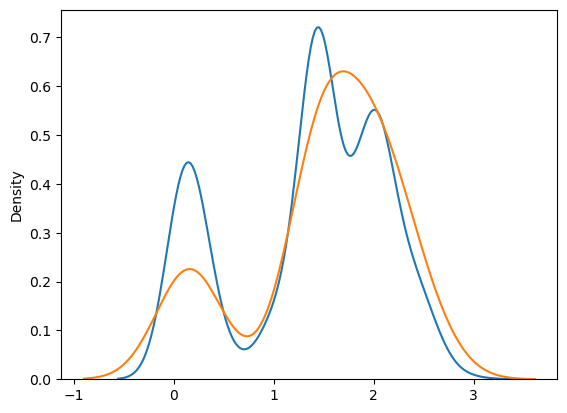

In [124]:
import seaborn as sns

sns.kdeplot(data=X[y==1])
sns.kdeplot(data=X[y==0])



# Other tries

In [125]:
np.mean(Distance_x1(data['real95']))

0.1350271687040686

In [126]:
np.mean(Distance_x1_x2(data['nfvae95'],data['real95']))

0.14400214996987643

In [127]:
np.mean(Distance_x1(data['nfvae95']))

0.028751693027323975

In [128]:
np.mean(Distance_x1_x2(data['real95'],data['nfvae95']))

0.7005246244701733

In [129]:
np.mean(Distance_x1_x2(data['real_excluded'],data['nfvae95']))

0.656447043317427

In [130]:
x =Distance_x1_x2(data['real_excluded'],data['nfvae95'])
x.shape

(213,)

In [131]:
y =Distance_x1_x2(data['nfvae95'],data['real_excluded'])
y.shape

(4039,)

In [132]:
np.mean(Distance_x1_x2(data['nfvae95'],data['real_excluded']))

0.294027450556145